# My playing with the Kaggle titanic challenge.

I COPPIED THE INITIAL CODE and got lots of the ideas for this first Kaggle advanture from [here](https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic/comments).

I will later compact the important stuff from here into a kernal on my Kaggle account.

In [1]:
import pandas as pd 
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.grid_search import GridSearchCV
import xgboost as xgb
from xgboost import plot_importance

train_df = pd.read_csv("train.csv",dtype={"Age":np.float64},)

In [2]:
#train_df.head()

In [3]:
# find how many ages
train_df['Age'].count()

714

In [4]:
# how many ages are NaN?
train_df['Age'].isnull().sum()

177

In [5]:
# plot ages of training data set, with NaN's removed
if False:
    train_df['Age'].dropna().astype(int).hist(bins=70)
print 'Mean age = ',train_df['Age'].dropna().astype(int).mean()

Mean age =  29.6792717087


# Let's see where they got on

In [6]:
#train_df['Embarked'].head()

In [7]:
#train_df.info()

In [8]:
train_df['Embarked'].isnull().sum()

2

In [9]:
train_df["Embarked"].count()

889

In [10]:
if False:
    sns.countplot(x="Embarked",data=train_df)

In [11]:
if False:
    sns.countplot(x='Survived',hue='Embarked',data=train_df,order=[0,1])

## OK, so clearly there were more people who got on at S, and it seems their survival is disproportional.  Let's check that.

In [12]:
if False:
    embark_survive_perc = train_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
    sns.barplot(x='Embarked', y='Survived', data=embark_survive_perc,order=['S','C','Q'])

## Interesting, actually those from C had higher rate of survival.  So, knowing more people from your home town didn't help.

## Next, did how much they paid have an effect?

In [13]:
if False:
    train_df['Fare'].astype(int).plot(kind='hist',bins=100, xlim=(0,50))

In [14]:
# get fare for survived & didn't survive passengers 
if False:
    fare_not_survived = train_df["Fare"].astype(int)[train_df["Survived"] == 0]
    fare_survived     = train_df["Fare"].astype(int)[train_df["Survived"] == 1]

    # get average and std for fare of survived/not survived passengers
    avgerage_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
    std_fare      = DataFrame([fare_not_survived.std(), fare_survived.std()])

    avgerage_fare.index.names = std_fare.index.names = ["Survived"]
    avgerage_fare.plot(yerr=std_fare,kind='bar',legend=False)

## Before digging into how the ages factor in, let's take the advice of others and replace NaN's with random values

In [15]:
import scipy.stats as stats

# column 'Age' has some NaN values
# A simple approximation of the distribution of ages is a gaussian, but this is not commonly accurate.
# lets make a vector of random ages centered on the mean, with a width of the std
lower, upper = train_df['Age'].min(), train_df['Age'].max()
mu, sigma = train_df["Age"].mean(), train_df["Age"].std()

# number of rows
n = train_df.shape[0]

print 'max: ',train_df['Age'].max()
print 'min: ',train_df['Age'].min()

# vector of random values using the truncated normal distribution.  
X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
rands = X.rvs(n)

# get the indexes of the elements in the original array that are NaN
idx = np.isfinite(train_df['Age'])

# use the indexes to replace the NON-NaNs in the random array with the good values from the original array
rands[idx.values] = train_df[idx]['Age'].values

## At this point rands is now the cleaned column of data we wanted, so push it in to the original df
train_df['Age'] = rands

"""
## we will make a new column with Nan's replaced, then push that into the original df
n = train_df.shape[0] # number of rows
#randy = np.random.randint(average_age_train - std_age_train, average_age_train + std_age_train, size = n)
# draw from a gaussian instead of simple uniform
# note this uses a 'standard gauss' and that tneeds to have its var and mean shifted
randy = np.random.randn(n)*std_age_train + average_age_train
idx = np.isfinite(train_df['Age']) # gives a boolean index for the NaNs in the df's column
randy[idx.values] = train_df[idx]['Age'].values  ## idexing the values of randy with this
#now have updated column, next push into original df
train_df['Age'] = randy
"""

print 'After this gaussian replacment, there are: ',train_df['Age'].isnull().sum()
print 'max: ',train_df['Age'].max()
print 'min: ',train_df['Age'].min()

max:  80.0
min:  0.42
After this gaussian replacment, there are:  0
max:  80.0
min:  0.42


In [16]:
# plot new Age Values
if False:
    train_df['Age'].hist(bins=70)
# Compare this to that from a few cells up for the raw ages with the NaN's dropped.  Not much different actually.

### lets perform the same NaN replacement for the 'Age' with the test data as well

In [17]:
## let's pull in the test data
test_df = pd.read_csv("test.csv",dtype={"Age":np.float64},)
#test_df.head()

In [18]:
#### Do the same for the test data
# column 'Age' has some NaN values
# A simple approximation of the distribution of ages is a gaussian, but this is not commonly accurate.
# lets make a vector of random ages centered on the mean, with a width of the std
lower, upper = test_df['Age'].min(), test_df['Age'].max()
mu, sigma = test_df["Age"].mean(), test_df["Age"].std()

# number of rows
n = test_df.shape[0]

print 'max: ',test_df['Age'].max()
print 'min: ',test_df['Age'].min()

# vector of random values using the truncated normal distribution.  
X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
rands = X.rvs(n)

# get the indexes of the elements in the original array that are NaN
idx = np.isfinite(test_df['Age'])

# use the indexes to replace the NON-NaNs in the random array with the good values from the original array
rands[idx.values] = test_df[idx]['Age'].values

## At this point rands is now the cleaned column of data we wanted, so push it in to the original df
test_df['Age'] = rands

max:  76.0
min:  0.17


In [19]:
#test_df['Age'].hist(bins=70)

In [20]:
## Let's make a couple nice plots of survival vs age
# peaks for survived/not survived passengers by their age
if False:
    facet = sns.FacetGrid(train_df, hue="Survived",aspect=4)
    #facet.map(sns.kdeplot,'Age',shade= True) # This keeps crashing the kernal, but I don't know why!!!!!!!!!!
    facet.set(xlim=(0, train_df['Age'].astype(int).max()))
    facet.add_legend()


In [21]:
# average survived passengers by age
if False:
    fig, axis1 = plt.subplots(1,1,figsize=(18,4))
    average_age = train_df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
    sns.barplot(x='Age', y='Survived', data=average_age)
    print 'max: ',train_df['Age'].astype(int).max()
    print 'min: ',train_df['Age'].astype(int).min()

In [22]:
# Cabin
# It has a lot of NaN values, so it won't cause a remarkable impact on prediction
train_df.drop("Cabin",axis=1,inplace=True)
test_df.drop("Cabin",axis=1,inplace=True)

In [23]:
#train_df.head()

In [24]:
# Family

# Instead of having two columns Parch & SibSp, 
# we can have only one column represent if the passenger had any family member aboard or not,
# Meaning, if having any family member(whether parent, brother, ...etc) will increase chances of Survival or not.
train_df['Family'] =  train_df["Parch"] + train_df["SibSp"]
train_df['Family'].loc[train_df['Family'] > 0] = 1
train_df['Family'].loc[train_df['Family'] == 0] = 0

test_df['Family'] =  test_df["Parch"] + test_df["SibSp"]
test_df['Family'].loc[test_df['Family'] > 0] = 1
test_df['Family'].loc[test_df['Family'] == 0] = 0

# drop Parch & SibSp
train_df = train_df.drop(['SibSp','Parch'], axis=1)
test_df    = test_df.drop(['SibSp','Parch'], axis=1)

# plot
if False:
    fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

    # sns.factorplot('Family',data=train_df,kind='count',ax=axis1)
    sns.countplot(x='Family', data=train_df, order=[1,0], ax=axis1)

    # average of survived for those who had/didn't have any family member
    family_perc = train_df[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
    sns.barplot(x='Family', y='Survived', data=family_perc, order=[1,0], ax=axis2)

    axis1.set_xticklabels(["With Family","Alone"], rotation=0)

/home/kmede/miniconda2/envs/ExoSOFTcondaEnv/lib/python2.7/site-packages/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [25]:
# Sex

# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
    
train_df['Person'] = train_df[['Age','Sex']].apply(get_person,axis=1)
test_df['Person']    = test_df[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
train_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
person_dummies_titanic  = pd.get_dummies(train_df['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
person_dummies_titanic.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

train_df = train_df.join(person_dummies_titanic)
test_df    = test_df.join(person_dummies_test)
if False:
    fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

    # sns.factorplot('Person',data=train_df,kind='count',ax=axis1)
    sns.countplot(x='Person', data=train_df, ax=axis1)

    # average of survived for each Person(male, female, or child)
    person_perc = train_df[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
    sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, order=['male','female','child'])

train_df.drop(['Person'],axis=1,inplace=True)
test_df.drop(['Person'],axis=1,inplace=True)

## Not surprising, woman and children had higher survival rates.

In [26]:
# Pclass

# sns.factorplot('Pclass',data=titanic_df,kind='count',order=[1,2,3])
if False:
    sns.factorplot('Pclass','Survived',order=[1,2,3], data=train_df,size=5)

# create dummy variables for Pclass column, & drop 3rd class as it has the lowest average of survived passengers
pclass_dummies_titanic  = pd.get_dummies(train_df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

train_df.drop(['Pclass'],axis=1,inplace=True)
test_df.drop(['Pclass'],axis=1,inplace=True)

train_df = train_df.join(pclass_dummies_titanic)
test_df    = test_df.join(pclass_dummies_test)

## Also unsurprising.  The higher the booking class, then higher the chances to survive.

___
___
___

# Now lets get to actually training and building a model to make predictions with!
___
___
___

## problems with the raw data
- a couple NaNs in 'Embarked', so drop column
- 'Name' strings can't be converted to anything useful, so drop column
- replace NaNs in 'Fare' with median
- 'Ticket' can't be converted to anything useful, so drop column
- 'PassengerID' has no importance, so drop column

In [27]:
#train_df.drop(['Embarked'], axis=1,inplace=True)
#test_df.drop(['Embarked'], axis=1,inplace=True)
# only for test_df, since there is a missing "Fare" values
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)
train_df.drop(['Name'], axis=1,inplace=True)
test_df.drop(['Name'], axis=1,inplace=True)

In [28]:
train_df.drop(['Ticket'], axis=1,inplace=True)
test_df.drop(['Ticket'], axis=1,inplace=True)

In [29]:
train_df.drop(['PassengerId'], axis=1,inplace=True)
#test_df.drop(['PassengerId'], axis=1,inplace=True)

In [30]:
# only in titanic_df, fill the two missing values with the most occurred value, which is "S".
train_df["Embarked"] = train_df["Embarked"].fillna("S")
# Either to consider Embarked column in predictions,
# and remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.

# OR, don't create dummy variables for Embarked column, just drop it, 
# because logically, Embarked doesn't seem to be useful in prediction.

embark_dummies_train  = pd.get_dummies(train_df['Embarked'])
#embark_dummies_train.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
#embark_dummies_test.drop(['S'], axis=1, inplace=True)

train_df = train_df.join(embark_dummies_train)
test_df    = test_df.join(embark_dummies_test)

train_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

# The names are also pointless, so drop them too

In [31]:
train_df.head()

,Survived,Age,Fare,Family,Child,Female,Class_1,Class_2,C,Q,S
0,0,22.0,7.2500,1,0,0,0,0,0,0,1
1,1,38.0,71.2833,1,0,1,1,0,1,0,0
2,1,26.0,7.9250,0,0,1,0,0,0,0,1
3,1,35.0,53.1000,1,0,1,1,0,0,0,1
4,0,35.0,8.0500,0,0,0,0,0,0,0,1


In [32]:
test_df.head()

,PassengerId,Age,Fare,Family,Child,Female,Class_1,Class_2,C,Q,S
0,892,34.5,7.8292,0,0,0,0,0,0,1,0
1,893,47.0,7.0000,1,0,1,0,0,0,0,1
2,894,62.0,9.6875,0,0,0,0,1,0,1,0
3,895,27.0,8.6625,0,0,0,0,0,0,0,1
4,896,22.0,12.2875,1,0,1,0,0,0,0,1


In [33]:
if False:
    print '\nFor train_df:'
    for column in train_df:
        print "# Nans in column '"+column+"' are: "+str(train_df[column].isnull().sum())
        print 'min: ',train_df[column].min()
        print 'max: ',train_df[column].max()

    print '\nFor test_df:'
    for column in test_df:
        print "# Nans in column '"+column+"' are: "+str(test_df[column].isnull().sum())
        print 'min: ',test_df[column].min()
        print 'max: ',test_df[column].max()   

In [34]:
# define training and testing sets
X_train = train_df.drop("Survived",axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId",axis=1).copy()

In [35]:
# Logistic Regression

logreg = LogisticRegression()

logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

print('standard score ', logreg.score(X_train, Y_train))
print('cv score ',np.mean(cross_val_score(logreg, X_train, Y_train, cv=10)))

('standard score ', 0.80808080808080807)
('cv score ', 0.79688684598796955)


In [36]:
# Random Forests
random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_test)

print('standard score ', random_forest.score(X_train, Y_train))
print('cv score ',np.mean(cross_val_score(random_forest, X_train, Y_train, cv=10)))

('standard score ', 0.98765432098765427)
('cv score ', 0.78238054704346838)


In [37]:
# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

# preview
coeff_df

,Features,Coefficient Estimate
0,Age,-0.019708
1,Fare,0.000834
2,Family,-0.073713
3,Child,1.393479
4,Female,2.668472
5,Class_1,1.909668
6,Class_2,1.092092
7,C,-0.079618
8,Q,-0.318296
9,S,-0.722187


In [38]:
if False:
    submission = pd.DataFrame({
            "PassengerId": test_df["PassengerId"],
            "Survived": Y_pred
        })
    submission.to_csv('submission.csv', index=False)

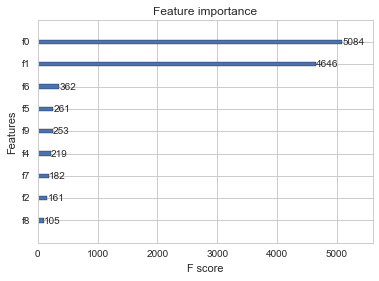

In [39]:
### Using XGboost
#X_train = train_df.drop("Survived",axis=1)
train_X = train_df.drop("Survived",axis=1).as_matrix()
train_y = train_df["Survived"]
test_X = test_df.drop("PassengerId",axis=1).copy().as_matrix()
model = xgb.XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.05)
model.fit(train_X, train_y)
predictions = model.predict(test_X)
# plot feature importance
plot_importance(model)
plt.show()
#X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.33, random_state=7)
#accuracy = accuracy_score(y_test, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))


In [40]:
# basic try at iterative training with XGboost
train_X = train_df.drop("Survived",axis=1).as_matrix()
train_y = train_df["Survived"]
test_X = test_df.drop("PassengerId",axis=1).copy().as_matrix()
# fit model on all training data
model = xgb.XGBClassifier(max_depth=5, n_estimators=300, learning_rate=0.05)

for i in range(10):
    print "Iteration: "+str(i)
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.33)#, random_state=7)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))



Iteration: 0
Accuracy: 80.34%
Iteration: 1
Accuracy: 81.69%
Iteration: 2
Accuracy: 77.63%
Iteration: 3
Accuracy: 73.22%
Iteration: 4
Accuracy: 82.03%
Iteration: 5
Accuracy: 80.34%
Iteration: 6
Accuracy: 77.63%
Iteration: 7
Accuracy: 77.29%
Iteration: 8
Accuracy: 83.39%
Iteration: 9
Accuracy: 82.37%


In [41]:
# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
# load data
#dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")
# split data into X and y
X = train_X
Y = train_y
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)
# fit model on all training data
model = XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.05)
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 75.93%
Thresh=0.000, n=10, Accuracy: 77.97%
Thresh=0.015, n=9, Accuracy: 77.97%
Thresh=0.022, n=8, Accuracy: 77.97%
Thresh=0.023, n=7, Accuracy: 78.98%
Thresh=0.024, n=6, Accuracy: 78.98%
Thresh=0.024, n=5, Accuracy: 80.00%
Thresh=0.029, n=4, Accuracy: 76.61%
Thresh=0.035, n=3, Accuracy: 69.83%
Thresh=0.370, n=2, Accuracy: 69.15%
Thresh=0.459, n=1, Accuracy: 57.63%


In [ ]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 

train_X = train_df.drop("Survived",axis=1).as_matrix()
train_y = train_df["Survived"]
test_X = test_df.drop("PassengerId",axis=1).copy().as_matrix()
#X = train_X
#Y = train_y
# split data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33
optimized_GBM.fit(train_X, train_y)
GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=7,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_child_weight': [1, 3, 5], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)